# Project: Predicting financial data 
## Part 1 - Mining media content
<b>Author:</b> Joeri van Wijngaarden<br>
<b>Date:</b> 17.03.2019<br>
<b>Source:</b> http://joerivanwijngaarden.com<br>
<b>Github:</b> http://github.com/tingidev/jvw-projects<p>

## News items variables

<ol>
    <li><strong>keywords</strong> - NLTK extracted keywords of text body</li>
    <li><strong>char_n</strong> - Number of characters in text body</li>
    <li><strong>title</strong> - Article's title</li>
    <li><strong>url</strong> - Article's url</li>
    <li><strong>text</strong> - Full article's text</li>
    <li><strong>brand</strong> - Newspaper brand where article was published</li>
    <li><strong>date</strong> - Date</li>
    <li><strong>date_str</strong> - Date as string</li>
    <li><strong>summary</strong> - NLTK extracted summary of text body</li>
</ol>


In [1]:
# Import friends
import os, sys
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import bson
from matplotlib.ticker import FormatStrFormatter
from matplotlib.font_manager import FontProperties
from matplotlib.cm import ScalarMappable
%matplotlib inline

# Plotting
import ast
from collections import Counter
from wordcloud import WordCloud

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

## Functions

In [2]:
# Wordcloud
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                         max_words=30, max_font_size=40,
                         random_state=42
                         ).generate(str(tup))
    return wordcloud

# News categories
def get_categories(text, brand):
    splt = text.split('/')
    if brand == 'nytimes':
        # nytimes has date before category section
        if len(splt) > 6:
            cat = splt[6]
        else:
            cat = ''
    else:
        cat = splt[3]
    return cat

# Tokenize
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('S'):
        return wordnet.ADJ_SAT
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV     
    else:
        return ''

def tokenize(text):
    '''
    Tokenize article text into a list of useful words.
    Excludes any stopwords, symbols and punctuation.
    Lemmatize each word to its stem.
    
    '''
    ps = PorterStemmer()
    lm = WordNetLemmatizer()
    try:
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ",text)
        tokens_ = word_tokenize(text)
        pos_tag = nltk.pos_tag(tokens_)
        tokens = []
        for w in pos_tag:
            if w[0].lower() not in stop_words and re.search('[a-zA-Z]', w[0]) and len(w[0]) >= 3:
                pos_val = get_wordnet_pos(w[1])
                if pos_val:
                    lemm = lm.lemmatize(w[0].lower(),pos_val)
                    tokens.append(lemm)
        return tokens    
    except TypeError as e: 
        print(text, e)

## Load data

In [4]:
# Loading news BSON files
base_folder = 'C:/Users/jvw/Dropbox/data_dumps/tingi-sandbox/'
dump_folder = ['dump_19_01_09','dump_19_02_03']
newsname = base_folder + dump_folder[0] + '/news_items.bson'
with open(newsname,'rb') as f:
    b = bson.decode_all(f.read())
news = pd.DataFrame(b)
for i in range(len(dump_folder)-1):
    newsname = base_folder + dump_folder[i+1] + '/news_items.bson'
    with open(newsname,'rb') as f:
        b = bson.decode_all(f.read())
    tmp = pd.DataFrame(b)
    news = news.append(tmp)

In [5]:
print('Size:',news.shape,'\n')
print(news.dtypes)
news.head(3)

Size: (65504, 10) 

_id                 object
brand               object
char_n               int64
date        datetime64[ns]
date_str            object
keywords            object
summary             object
text                object
title               object
url                 object
dtype: object


,_id,brand,char_n,date,date_str,keywords,summary,text,title,url
0,5c05a86fd1744313db2b4393,theguardian,7197,2018-12-03 22:04:31.204,2018-12-03,"[insane, return, trump, 1965, camp, political,...",It’s a testament to Knebel’s skill that Night ...,“Nobody in this country can tell a president o...,Night of Camp David: the return of a 1965 book...,https://www.theguardian.com/books/2018/nov/30/...
1,5c05a870d1744313db2b4394,theguardian,4667,2018-12-03 22:04:32.299,2018-12-03,"[duty, different, peace, love, shaped, father,...",And your men are under a different command now...,"Before he was president, Bush was a young nava...",'A different command': how George HW Bush's wa...,https://www.theguardian.com/us-news/2018/dec/0...
2,5c05a871d1744313db2b4395,theguardian,4361,2018-12-03 22:04:33.523,2018-12-03,"[andaluca, pp, right, franco, far, wins, regio...","Until recently, the entire right spectrum – fr...",Far right wins seats in Spanish region for fir...,Far right wins seats in Spanish region for fir...,https://www.theguardian.com/world/2018/dec/03/...


In [6]:
# Clean data by removing cbsnews (only 3 entries from testing)
tmp = news.loc[news['brand']=='cbsnews']
news = news.drop(tmp.index)

In [7]:
# Extract categories from URL
news['category'] = news[['url','brand']].apply(lambda x: get_categories(x['url'], x['brand']), axis=1)

In [8]:
# News outlets included in dataset
brands = np.sort(news['brand'].unique())
places = ['Japan','USA','Hong Kong','UK']
i=0
tot_n = 0

for brand in brands:
    grouped = news.loc[news['brand']==brand].groupby('date_str')
    mean_n = int(np.mean(grouped['date'].size().values))
    tot_n += mean_n
    print('Newspaper:',brand.upper(),'('+places[i]+') -',mean_n,'articles')
    i+=1
print('Total:',tot_n,'articles per day')

Newspaper: JAPANTIMES (Japan) - 407 articles
Newspaper: NYTIMES (USA) - 108 articles
Newspaper: SCMP (Hong Kong) - 799 articles
Newspaper: THEGUARDIAN (UK) - 139 articles
Total: 1453 articles per day


In [9]:
# Days of gathered media
days = news['date_str'].unique()
print('Number of days:',len(days))
print('First day:',days[0])
print('Last day:',days[-1],'\n')
print(days)

Number of days: 45
First day: 2018-12-03
Last day: 2019-02-01 

['2018-12-03' '2018-12-04' '2018-12-05' '2018-12-06' '2018-12-07'
 '2018-12-10' '2018-12-11' '2018-12-12' '2018-12-13' '2018-12-14'
 '2018-12-17' '2018-12-18' '2018-12-19' '2018-12-20' '2018-12-21'
 '2018-12-24' '2018-12-25' '2018-12-26' '2018-12-27' '2018-12-28'
 '2018-12-31' '2019-01-01' '2019-01-02' '2019-01-03' '2019-01-04'
 '2019-01-07' '2019-01-08' '2019-01-09' '2019-01-10' '2019-01-11'
 '2019-01-14' '2019-01-15' '2019-01-16' '2019-01-17' '2019-01-18'
 '2019-01-21' '2019-01-22' '2019-01-23' '2019-01-24' '2019-01-25'
 '2019-01-28' '2019-01-29' '2019-01-30' '2019-01-31' '2019-02-01']


## General overview of newspapers (unused & Fig. 6 & 7)

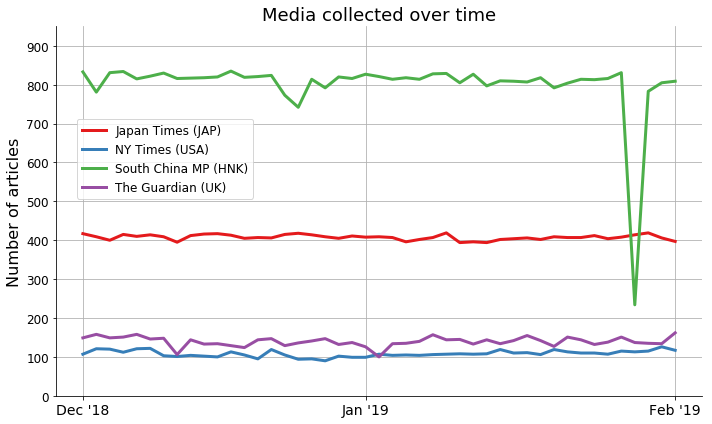

In [10]:
col = plt.get_cmap('Set1')
fig, ax = plt.subplots(figsize=(10,6))
leg = ['Japan Times (JAP)','NY Times (USA)','South China MP (HNK)','The Guardian (UK)']
ticks = [0,21,44]
i = 0

for brand in brands:
    grouped = news.loc[news['brand']==brand].groupby('date_str')
    ax.plot(grouped['date'].size().values, linewidth=3, color=col.colors[i])
    ax.set_xlim(-2,len(days)+1)
    ax.set_ylim(0,950)
    ax.set_yticks(np.linspace(0,900,10))
    ax.set_xticks(ticks)
    ax.set_xticklabels(['Dec \'18','Jan \'19','Feb \'19'])
    ax.set_title('Media collected over time', fontsize=18)
    ax.set_ylabel('Number of articles', fontsize=16)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
    i+=1
    
fig.legend(leg, bbox_to_anchor=(.36,.72), fontsize=12)
ax.grid(True)

fig.tight_layout()
# plt.savefig('./images/unused.png')

There are 22 unique categories in japantimes
There are 57 unique categories in nytimes
There are 41 unique categories in scmp
There are 156 unique categories in theguardian


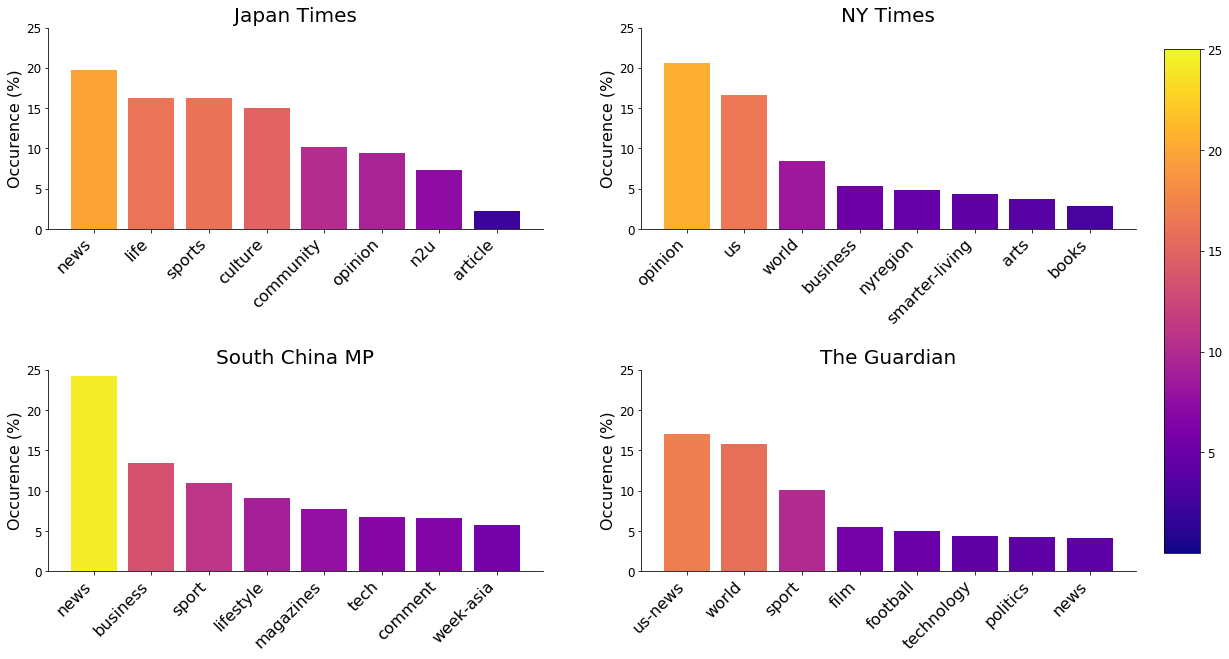

In [11]:
# Distribution of categories across newspapers
cmap = plt.get_cmap('plasma')
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
fig.subplots_adjust(hspace=0.7)
ttl = ['Japan Times','NY Times','South China MP','The Guardian']
size = 8
i = 0
for brand in brands:
    grouped = news.loc[news['brand']==brand]
    categories = grouped['category'].values.tolist()
    print("There are %d unique categories in " % len(set(categories)) + brand )
    ticks = [x[0] for x in Counter(categories).most_common(size)]
    vals = [x[1]/len(categories)*100 for x in Counter(categories).most_common(size)]
    col = [cmap(x/25) for x in vals]
    im = fig.axes[i].bar(range(size), vals, color=col)
    fig.axes[i].set_xticks(range(size))
    fig.axes[i].set_xticklabels(ticks, rotation=45, ha="right")
    fig.axes[i].set_ylim([0,25])
    fig.axes[i].set_title(ttl[i], fontsize=20)
    fig.axes[i].set_ylabel('Occurence (%)', fontsize=16)
    fig.axes[i].spines['right'].set_visible(False)
    fig.axes[i].spines['top'].set_visible(False)  
    fig.axes[i].tick_params(axis='y', which='major', labelsize=12)
    fig.axes[i].tick_params(axis='x', which='major', labelsize=16)
    i += 1
    
# Colorbar
sm = ScalarMappable(cmap=cmap)
sm.set_array([0, 25])
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])
cb = fig.colorbar(sm, cax=cbar_ax, ticks=np.linspace(5,25,5))
cb.ax.tick_params(labelsize=12)
# plt.savefig('./images/fig6.png', bbox_inches='tight')

In [12]:
# Unique keywords
list_of_keywords = news['keywords'].values.flatten()
all_keywords = [item for sublist in list_of_keywords for item in sublist]
print("There are %d unique keywords across all articles." % len(set(all_keywords)))
print("There are %d total keywords." % len(all_keywords))
most_common=Counter(all_keywords).most_common(50)
most_common[:10]

There are 33320 unique keywords across all articles.
There are 1013087 total keywords.


[('china', 10245),
 ('hong', 9701),
 ('kong', 8644),
 ('chinese', 8348),
 ('world', 6285),
 ('japan', 5506),
 ('chinas', 4737),
 ('cent', 4244),
 ('trade', 3988),
 ('trump', 3884)]

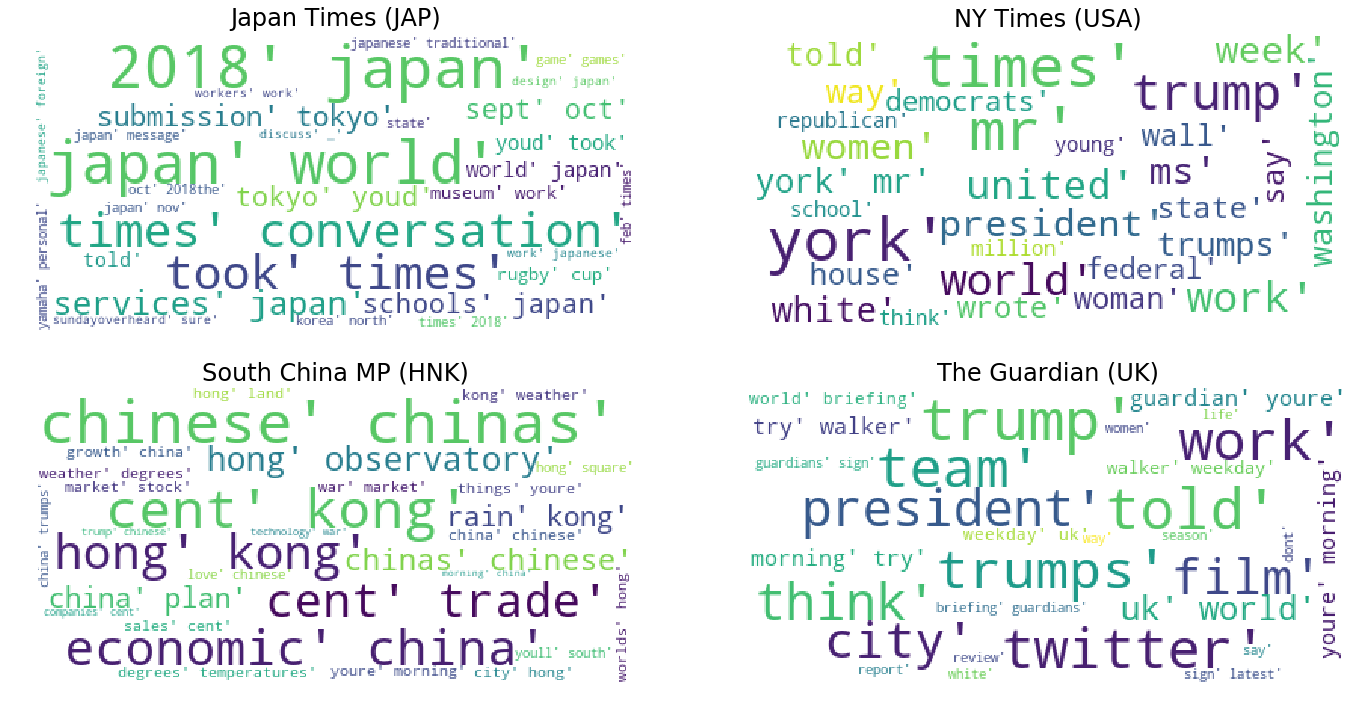

In [13]:
# Generate wordcloud for each newspaper
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
i = 0
for brand in brands:
    list_of_keywords = news.loc[news['brand']==brand]['keywords'].values.flatten()
    all_keywords = [item for sublist in list_of_keywords for item in sublist]
    img = generate_wordcloud(all_keywords)
    fig.axes[i].imshow(img)
    fig.axes[i].axis('off')
    fig.axes[i].set_title(leg[i], fontsize=24)
    i+=1
fig.tight_layout()
# plt.savefig('./images/fig7.png')

## Tokenize & example

In [14]:
# Tokenize summary (takes some minutes)
news['tokens'] = news['summary'].map(tokenize)

In [15]:
# Print examples
for text, summary, tokens, keywords in zip(news['text'].head(8), news['summary'].head(8), 
                                           news['tokens'].head(8), news['keywords'].head(8)):
    print(text)
    print(summary)
    print(tokens)
    print(keywords)
    print(' ')

“Nobody in this country can tell a president of the United States that his mind is sick.” That’s the blunt assessment of the defense secretary in Night of Camp David, a political thriller from 1965 that stands to be rescued from an undeserved obscurity by its republication this month.

The coal-black front cover of the new edition is unadorned apart from one line, in white block letters: “What would happen if the president of the USA went stark-raving mad?”

From Brexit to the US election: books that reveal how Russia influences the world Read more

The book plunges into the quandary faced by Jim MacVeagh, a junior senator from Iowa when he realizes, based on private midnight conversations at the Maryland country retreat of the title, that the president, an otherwise heroic Democrat, has grown dangerously paranoid and hatched unhinged ideas about remaking the international order.

The prospect of a commander-in-chief who has lost command of reality is terrifying to MacVeagh, and to a s

## Term frequency-inversed document frequency (TF-IDF) & example (Fig. 8)

In [16]:
# Apply tf-idf function to summary data
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_features = 100000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   tokenizer=tokenize,
                                   max_features=n_features,
                                   ngram_range=(1, 1))

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                tokenizer=tokenize,
                                max_features=n_features,
                                ngram_range=(1, 1))

# Run it for theguardian as an example
brand = brands[1]
grouped = news.loc[news['brand']==brand]['summary'].values

tf = tf_vectorizer.fit_transform(list(grouped))
tfidf = tfidf_vectorizer.fit_transform(list(grouped))

In [17]:
# Save all vectorizers
save_vect = open("./pickled/tf_vectorizer.pickle","wb")
pickle.dump(tf_vectorizer, save_vect)
save_vect.close()

save_vect = open("./pickled/tfidf_vectorizer.pickle","wb")
pickle.dump(tfidf_vectorizer, save_vect)
save_vect.close()

save_vect = open("./pickled/tf.pickle","wb")
pickle.dump(tf, save_vect)
save_vect.close()

save_vect = open("./pickled/tfidf.pickle","wb")
pickle.dump(tfidf, save_vect)
save_vect.close()

In [18]:
# Load all vectorizers
vect_f = open("./pickled/tf_vectorizer.pickle","rb")
tf_vectorizer = pickle.load(vect_f)
vect_f.close()

vect_f = open("./pickled/tfidf_vectorizer.pickle","rb")
tfidf_vectorizer = pickle.load(vect_f)
vect_f.close()

vect_f = open("./pickled/tf.pickle","rb")
tf = pickle.load(vect_f)
vect_f.close()

vect_f = open("./pickled/tfidf.pickle","rb")
tfidf = pickle.load(vect_f)
vect_f.close()

In [19]:
# TF counts for corpus
count = dict(zip(tf_vectorizer.get_feature_names(), tf.toarray().sum(axis=0)))
tfmat = pd.DataFrame().from_dict(count, orient='index')
tfmat.columns = ['Total count']
tfmat.sort_values(by='Total count', ascending=False).head(10).transpose()

,say,new,year,trump,time,state,make,president,york,people
Total count,3462,2145,1932,1729,1608,1392,1194,1142,1062,1030


In [20]:
# TF counts for example article
example = grouped[10]
print(example)
count_example = Counter(tokenize(example))
xxx = pd.DataFrame().from_dict(count_example, orient='index')
xxx.columns = ['Example count']
xxx.sort_values(by='Example count', ascending=False).head(10).transpose()

Mr. Lighthizer — who is known as a tough negotiator with an encyclopedic knowledge of trade law — is a longtime China skeptic who has repeatedly cautioned Mr. Trump not to accept vague Chinese promises that fail to materialize.
Mr. Lighthizer will be taking the reins from Steven Mnuchin, the Treasury secretary, who led previous rounds of negotiations with the Chinese but was unable to close a deal that satisfied the president.
Deep differences remain, particularly related to China’s treatment of American companies and what the White House says is a pattern of coercing technology and trade secrets from firms.
“I do think that Ambassador Lighthizer is the best trade negotiator in the business,” Mr. Kudlow, the director of the White House’s National Economic Council, said during a briefing on Monday afternoon.
For instance, after leaving Buenos Aires on Saturday night, Mr. Trump told reporters aboard Air Force One that Mr. Xi had agreed to approve a tech deal it had previously rejected be

,lighthizer,trade,china,firm,say,house,deal,chinese,trump,white
Example count,3,3,2,2,2,2,2,2,2,2


In [21]:
# TF-IDF for example article
score = dict(zip(tfidf_vectorizer.get_feature_names(), np.around(tfidf.toarray()[10], 2)))
tfidfmat = pd.DataFrame().from_dict(score, orient='index')
tfidfmat.columns = ['Example tf-idf']
tfidfmat.sort_values(by='Example tf-idf', ascending=False).head(10).transpose()

,lighthizer,trade,negotiator,firm,chinese,encyclopedic,china,nxp,white,deal
Example tf-idf,0.34,0.22,0.22,0.17,0.16,0.14,0.14,0.14,0.13,0.13
